# IS843 Team Project - Spotify Music Popularity Analysis
# Team Members: Ditstat Somsirivatana, Xinyu Guo, Julia Nicholson

In this project, we will explore what makes music popular.  We plan to analyze the trends between music characteristics and listening behavior on the Spotify application.  Spotify is an international media services company that provides access to over 50 million tracks. As of February 2020, the company had 271 million monthly active users, including 124 million paying subscribers. Thus, we consider Spotify a reliable and timely indicator for music popularity, and it also provides complete information and technical data for tracks. 

Some of the questions that we hope to address are:
What music genre is most popular? 
Is there an average song duration that predicts popularity? 
Is there a speech type that predicts popularity?
Is there a specific tempo that predicts popularity?
Is there a song energy level that predicts popularity?
Are movie soundtracks more popular than music not produced for a movie soundtrack?
What song characteristics predict whether the song has high or low danceability?
What song characteristics predict whether the song has high or low energy?
What song characteristics predict whether the song has high or low livliness?


The dataset for our project is based on the following link from Kaggle:
https://www.kaggle.com/zaheenhamidani/ultimate-spotify-tracks-db

## Libraries Used

In [1]:
from pyspark.sql.types import StructField, StructType, StringType, IntegerType, FloatType
import pyspark.sql.functions as F
from pyspark.sql import Window
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
plt.style.use('seaborn')

## 1.  Data Overview

###  Spotify Audio Feature Definitions

| Column Name | Definition |
| --- | --- | --- |
| **Genre** | Genre |
| **Artist_name** | Artist name |
| **Track_name** | Song name |
| **Track_id** | The Sptofy identifier that you can find at the end of the Spotify URI for a track |
| **Acousticness **| A confidence measure from 0.0 to 1.0 of whether the track is acoustic. 1.0 represents high confidence the track is acoustic. |
| **Danceability** | How suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity. A value of 0.0 is least danceable and 1.0 is most danceable.  |
| **Duration_ms** | The duration of the track in milliseconds. |
| **Energy** | Energy is a measure from 0.0 to 1.0 and represents a perceptual measure of intensity and activity. Typically, energetic tracks feel fast, loud, and noisy.  |
| **Instrumentalness** | Predicts whether a track contains no vocals. “Ooh” and “aah” sounds are treated as instrumental in this context. Rap or spoken word tracks are clearly “vocal”. The closer the instrumentalness value is to 1.0, the greater likelihood the track contains no vocal content. Values above 0.5 are intended to represent instrumental tracks, but confidence is higher as the value approaches 1.0.   |
| **Key** | The estimated overall key of the track. Integers map to pitches using standard Pitch Class notation.  E.g. 0 = C, 1 = C♯/D♭, 2 = D, and so on. If no key was detected, the value is -1. |
| **Liveness** | Detects the presence of an audience in the recording. Higher liveness values represent an increased probability that the track was performed live. A value above 0.8 provides strong likelihood that the track is live.   |
| **Loudness** | The overall loudness of a track in decibels (dB). Loudness values are averaged across the entire track and are useful for comparing relative loudness of tracks. Loudness is the quality of a sound that is the primary psychological correlate of physical strength (amplitude). Values typical range between -60 and 0 db.    |
| **Mode** | Mode indicates the modality (major or minor) of a track, the type of scale from which its melodic content is derived. Major is represented by 1 and minor is 0.    |
|**Speechiness** | Speechiness detects the presence of spoken words in a track. The more exclusively speech-like the recording (e.g. talk show, audio book, poetry), the closer to 1.0 the attribute value. Values above 0.66 describe tracks that are probably made entirely of spoken words. Values between 0.33 and 0.66 describe tracks that may contain both music and speech, either in sections or layered, including such cases as rap music. Values below 0.33 most likely represent music and other non-speech-like tracks.    |
| **Tempo** | The overall estimated tempo of a track in beats per minute (BPM). In musical terminology, tempo is the speed or pace of a given piece and derives directly from the average beat duration.    |
| **Time_signature** | An estimated overall time signature of a track. The time signature (meter) is a notational convention to specify how many beats are in each bar (or measure).   |
| **Valence** | A measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry).    |

## 2.  Data Loading and Cleaning

### 2.1 Loading Raw Data

In [2]:
data = "gs://is843-team4/data/"

In [3]:
myschema = StructType([
  StructField('genre', StringType(), True),
  StructField('artist_name', StringType(), True),
  StructField('track_name', StringType(), True),
  StructField('track_id', StringType(), True),
  StructField('popularity', IntegerType(), True),
  StructField('acousticness', FloatType(), True),
  StructField('danceability',  FloatType(), True),
  StructField('duration_ms', FloatType(), True),
  StructField('energy',  FloatType(), True),
  StructField('instrumentalness',  FloatType(), True),
  StructField('key', StringType(), True),
  StructField('liveness', FloatType(), True),
  StructField('loudness',  FloatType(), True),
  StructField('mode',  StringType(), True),
  StructField('speechiness', FloatType(), True),
  StructField('tempo',  FloatType(), True),
  StructField('time_signature',  StringType(), True),
  StructField('valence', FloatType(), True)  
])

In [4]:
# df = spark.read.format("csv").option("header", "true").option("inferSchema", "true").load(data + "SpotifyFeatures.csv")
df = spark.read.format("csv").option("header", "true").schema(myschema).load(data + "SpotifyFeatures.csv")

In [5]:
df.printSchema()

root
 |-- genre: string (nullable = true)
 |-- artist_name: string (nullable = true)
 |-- track_name: string (nullable = true)
 |-- track_id: string (nullable = true)
 |-- popularity: integer (nullable = true)
 |-- acousticness: float (nullable = true)
 |-- danceability: float (nullable = true)
 |-- duration_ms: float (nullable = true)
 |-- energy: float (nullable = true)
 |-- instrumentalness: float (nullable = true)
 |-- key: string (nullable = true)
 |-- liveness: float (nullable = true)
 |-- loudness: float (nullable = true)
 |-- mode: string (nullable = true)
 |-- speechiness: float (nullable = true)
 |-- tempo: float (nullable = true)
 |-- time_signature: string (nullable = true)
 |-- valence: float (nullable = true)



In [6]:
df.show(5, False)

+-----+-----------------+--------------------------------+----------------------+----------+------------+------------+-----------+------+----------------+---+--------+--------+-----+-----------+-------+--------------+-------+
|genre|artist_name      |track_name                      |track_id              |popularity|acousticness|danceability|duration_ms|energy|instrumentalness|key|liveness|loudness|mode |speechiness|tempo  |time_signature|valence|
+-----+-----------------+--------------------------------+----------------------+----------+------------+------------+-----------+------+----------------+---+--------+--------+-----+-----------+-------+--------------+-------+
|Movie|Henri Salvador   |C'est beau de faire un Show     |0BRjO6ga9RKCKjfDqeFgWV|0         |0.611       |0.389       |99373.0    |0.91  |0.0             |C# |0.346   |-1.828  |Major|0.0525     |166.969|4/4           |0.814  |
|Movie|Martin & les fées|Perdu d'avance (par Gad Elmaleh)|0BjC1NfoEOOusryehmNudP|1         |0.24

In [5]:
df.cache()

DataFrame[genre: string, artist_name: string, track_name: string, track_id: string, popularity: int, acousticness: float, danceability: float, duration_ms: float, energy: float, instrumentalness: float, key: string, liveness: float, loudness: float, mode: string, speechiness: float, tempo: float, time_signature: string, valence: float]

##  2.2 Checking Duplicate and Null Values in data

### First, we check if there are any duplicate rows:

In [8]:
w = Window.partitionBy('track_name').orderBy('track_name')
df.select('*', F.count('track_name').over(w).alias('dupeCount'))\
    .where('dupeCount > 1')\
    .drop('dupeCount')\
    .show(5)

+-----------+-----------+--------------------+--------------------+----------+------------+------------+-----------+------+----------------+---+--------+--------+-----+-----------+-------+--------------+-------+
|      genre|artist_name|          track_name|            track_id|popularity|acousticness|danceability|duration_ms|energy|instrumentalness|key|liveness|loudness| mode|speechiness|  tempo|time_signature|valence|
+-----------+-----------+--------------------+--------------------+----------+------------+------------+-----------+------+----------------+---+--------+--------+-----+-----------+-------+--------------+-------+
| Electronic|Lemon Jelly|'75 aka Stay With...|4vyLcnuVAwrLOf46w...|        51|      0.0307|       0.712|   371507.0| 0.827|           0.795| C#|   0.122|  -7.331|Major|     0.0414|126.001|           4/4|  0.305|
|       Jazz|Lemon Jelly|'75 aka Stay With...|4vyLcnuVAwrLOf46w...|        52|      0.0307|       0.712|   371507.0| 0.827|           0.795| C#|   0.122

The results show duplicates, so we remove them

In [9]:
print('Original dataframe contains {} rows'.format(df.count()))
df = df.drop_duplicates()
print('After removing duplicates, the dataframe contains {} rows'.format(df.count()))

Original dataframe contains 223372 rows
After removing duplicates, the dataframe contains 222352 rows


### Second, we check to see if there are any Null values:

In [10]:
df.select([F.count(F.when(F.isnull(c), c)).alias(c) for c in df.columns]).show()

+-----+-----------+----------+--------+----------+------------+------------+-----------+------+----------------+---+--------+--------+----+-----------+-----+--------------+-------+
|genre|artist_name|track_name|track_id|popularity|acousticness|danceability|duration_ms|energy|instrumentalness|key|liveness|loudness|mode|speechiness|tempo|time_signature|valence|
+-----+-----------+----------+--------+----------+------------+------------+-----------+------+----------------+---+--------+--------+----+-----------+-----+--------------+-------+
|    1|          1|         1|       1|         1|           1|           1|          1|     1|               1|  1|       1|       1|   1|          1|    1|             1|      1|
+-----+-----------+----------+--------+----------+------------+------------+-----------+------+----------------+---+--------+--------+----+-----------+-----+--------------+-------+



We found 1 Null value in our dataset! Let's see if they are in the same row or not.

In [11]:
df.where(df.genre.isNull()).show()

+-----+-----------+----------+--------+----------+------------+------------+-----------+------+----------------+----+--------+--------+----+-----------+-----+--------------+-------+
|genre|artist_name|track_name|track_id|popularity|acousticness|danceability|duration_ms|energy|instrumentalness| key|liveness|loudness|mode|speechiness|tempo|time_signature|valence|
+-----+-----------+----------+--------+----------+------------+------------+-----------+------+----------------+----+--------+--------+----+-----------+-----+--------------+-------+
| null|       null|      null|    null|      null|        null|        null|       null|  null|            null|null|    null|    null|null|       null| null|          null|   null|
+-----+-----------+----------+--------+----------+------------+------------+-----------+------+----------------+----+--------+--------+----+-----------+-----+--------------+-------+



The results show the null values are from the same row. So, we will remove this:

In [12]:
print('Original dataframe contains {} rows'.format(df.count()))
df = df.na.drop()
print('After removing duplicates, the dataframe contains {} rows'.format(df.count()))

Original dataframe contains 222352 rows
After removing duplicates, the dataframe contains 222351 rows


# 3. Exploratory Data Analysis

## 3.1 Basic summary

Since one song could be catogorized in several different genres in our dataset, we create another dataframe that removes the genre of songs. According to the result below, there is a total of 190052 unique songs in our dataset.


In [13]:
df_single = df.drop('genre').drop_duplicates()
df_single.count()

185585

### All Track Genres:

In [14]:
df.select('genre').distinct().show(30, False)

+----------------+
|genre           |
+----------------+
|World           |
|Ska             |
|Rock            |
|Jazz            |
|Soundtrack      |
|Folk            |
|Classical       |
|Blues           |
|R&B             |
|Anime           |
|Alternative     |
|Movie           |
|A Capella       |
|Pop             |
|Reggaeton       |
|Soul            |
|Rap             |
|Reggae          |
|Electronic      |
|Children's Music|
|Country         |
|Comedy          |
|Dance           |
|Indie           |
|Hip-Hop         |
|Opera           |
+----------------+



### Top 5 Most Popular Genres:

In [15]:
df.groupBy('genre').agg(F.mean('popularity').alias('popularity')).select('genre', F.round('popularity', 2).alias('popularity')).orderBy(F.desc('popularity')).show(5, False)

+-------+----------+
|genre  |popularity|
+-------+----------+
|Pop    |66.59     |
|Rap    |60.53     |
|Rock   |59.62     |
|Hip-Hop|58.42     |
|Dance  |57.28     |
+-------+----------+
only showing top 5 rows



As the name suggests, Pop is the most popular genre in Spotify!

### Top 10 Most Popular Songs:

In [16]:
df_single.select('track_name','artist_name','popularity').orderBy(F.desc('popularity')).distinct().show(10, False)

+---------------------------------------------+-------------+----------+
|track_name                                   |artist_name  |popularity|
+---------------------------------------------+-------------+----------+
|7 rings                                      |Ariana Grande|100       |
|Wow.                                         |Post Malone  |99        |
|break up with your girlfriend, i'm bored     |Ariana Grande|99        |
|Con Calma                                    |Daddy Yankee |98        |
|Dancing With A Stranger (with Normani)       |Sam Smith    |97        |
|Sunflower - Spider-Man: Into the Spider-Verse|Post Malone  |97        |
|Calma - Remix                                |Pedro Capó   |97        |
|Sweet but Psycho                             |Ava Max      |97        |
|Without Me                                   |Halsey       |97        |
|Happier                                      |Marshmello   |97        |
+---------------------------------------------+----

### Top 10 Most Popular Artists:

In [17]:
df_single.groupBy('artist_name').agg(F.mean('popularity').alias('popularity')).select('artist_name', 'popularity').orderBy(F.desc('popularity')).show(10, False)

+--------------------+-----------------+
|artist_name         |popularity       |
+--------------------+-----------------+
|Pedro Capó          |87.0             |
|Mario Bautista      |85.0             |
|Mau y Ricky         |83.0             |
|Ninho               |82.0             |
|Kris Kross Amsterdam|82.0             |
|Martin Garrix       |81.85714285714286|
|Sofia Reyes         |81.5             |
|Paloma Mami         |81.0             |
|NSG                 |81.0             |
|Kenny Man           |81.0             |
+--------------------+-----------------+
only showing top 10 rows



## 3.2 Data Visualization

In [18]:
df_pandas = df.toPandas().dropna()

__First, we want to see the distribution of the popularity variable because this would be our predictive varible in our future analysis.__

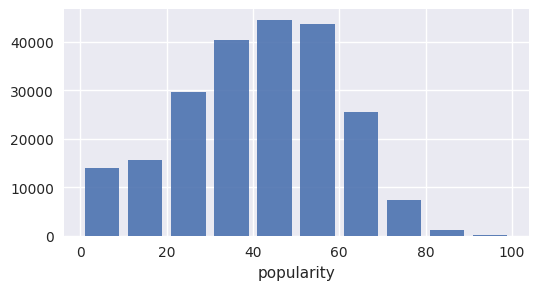

In [19]:
plt.figure(figsize=(6,3), dpi=100)
sns.distplot(df_pandas.popularity, kde=False, bins = 10, hist_kws=dict(alpha=0.9, rwidth=0.8))
plt.show()

From the figure above, we can see that the popularity of most songs is in the range of 30 to 70 while only very few songs' popularity is greater than 80. On the contrary, there is quite a lot of samples that have 0 popularity. We think this is normal because there may be certain genres that are not aprreciated by people based on their individual listening preferences. 

__Then, we want to see the approximate distribution of several features in the dataset:__

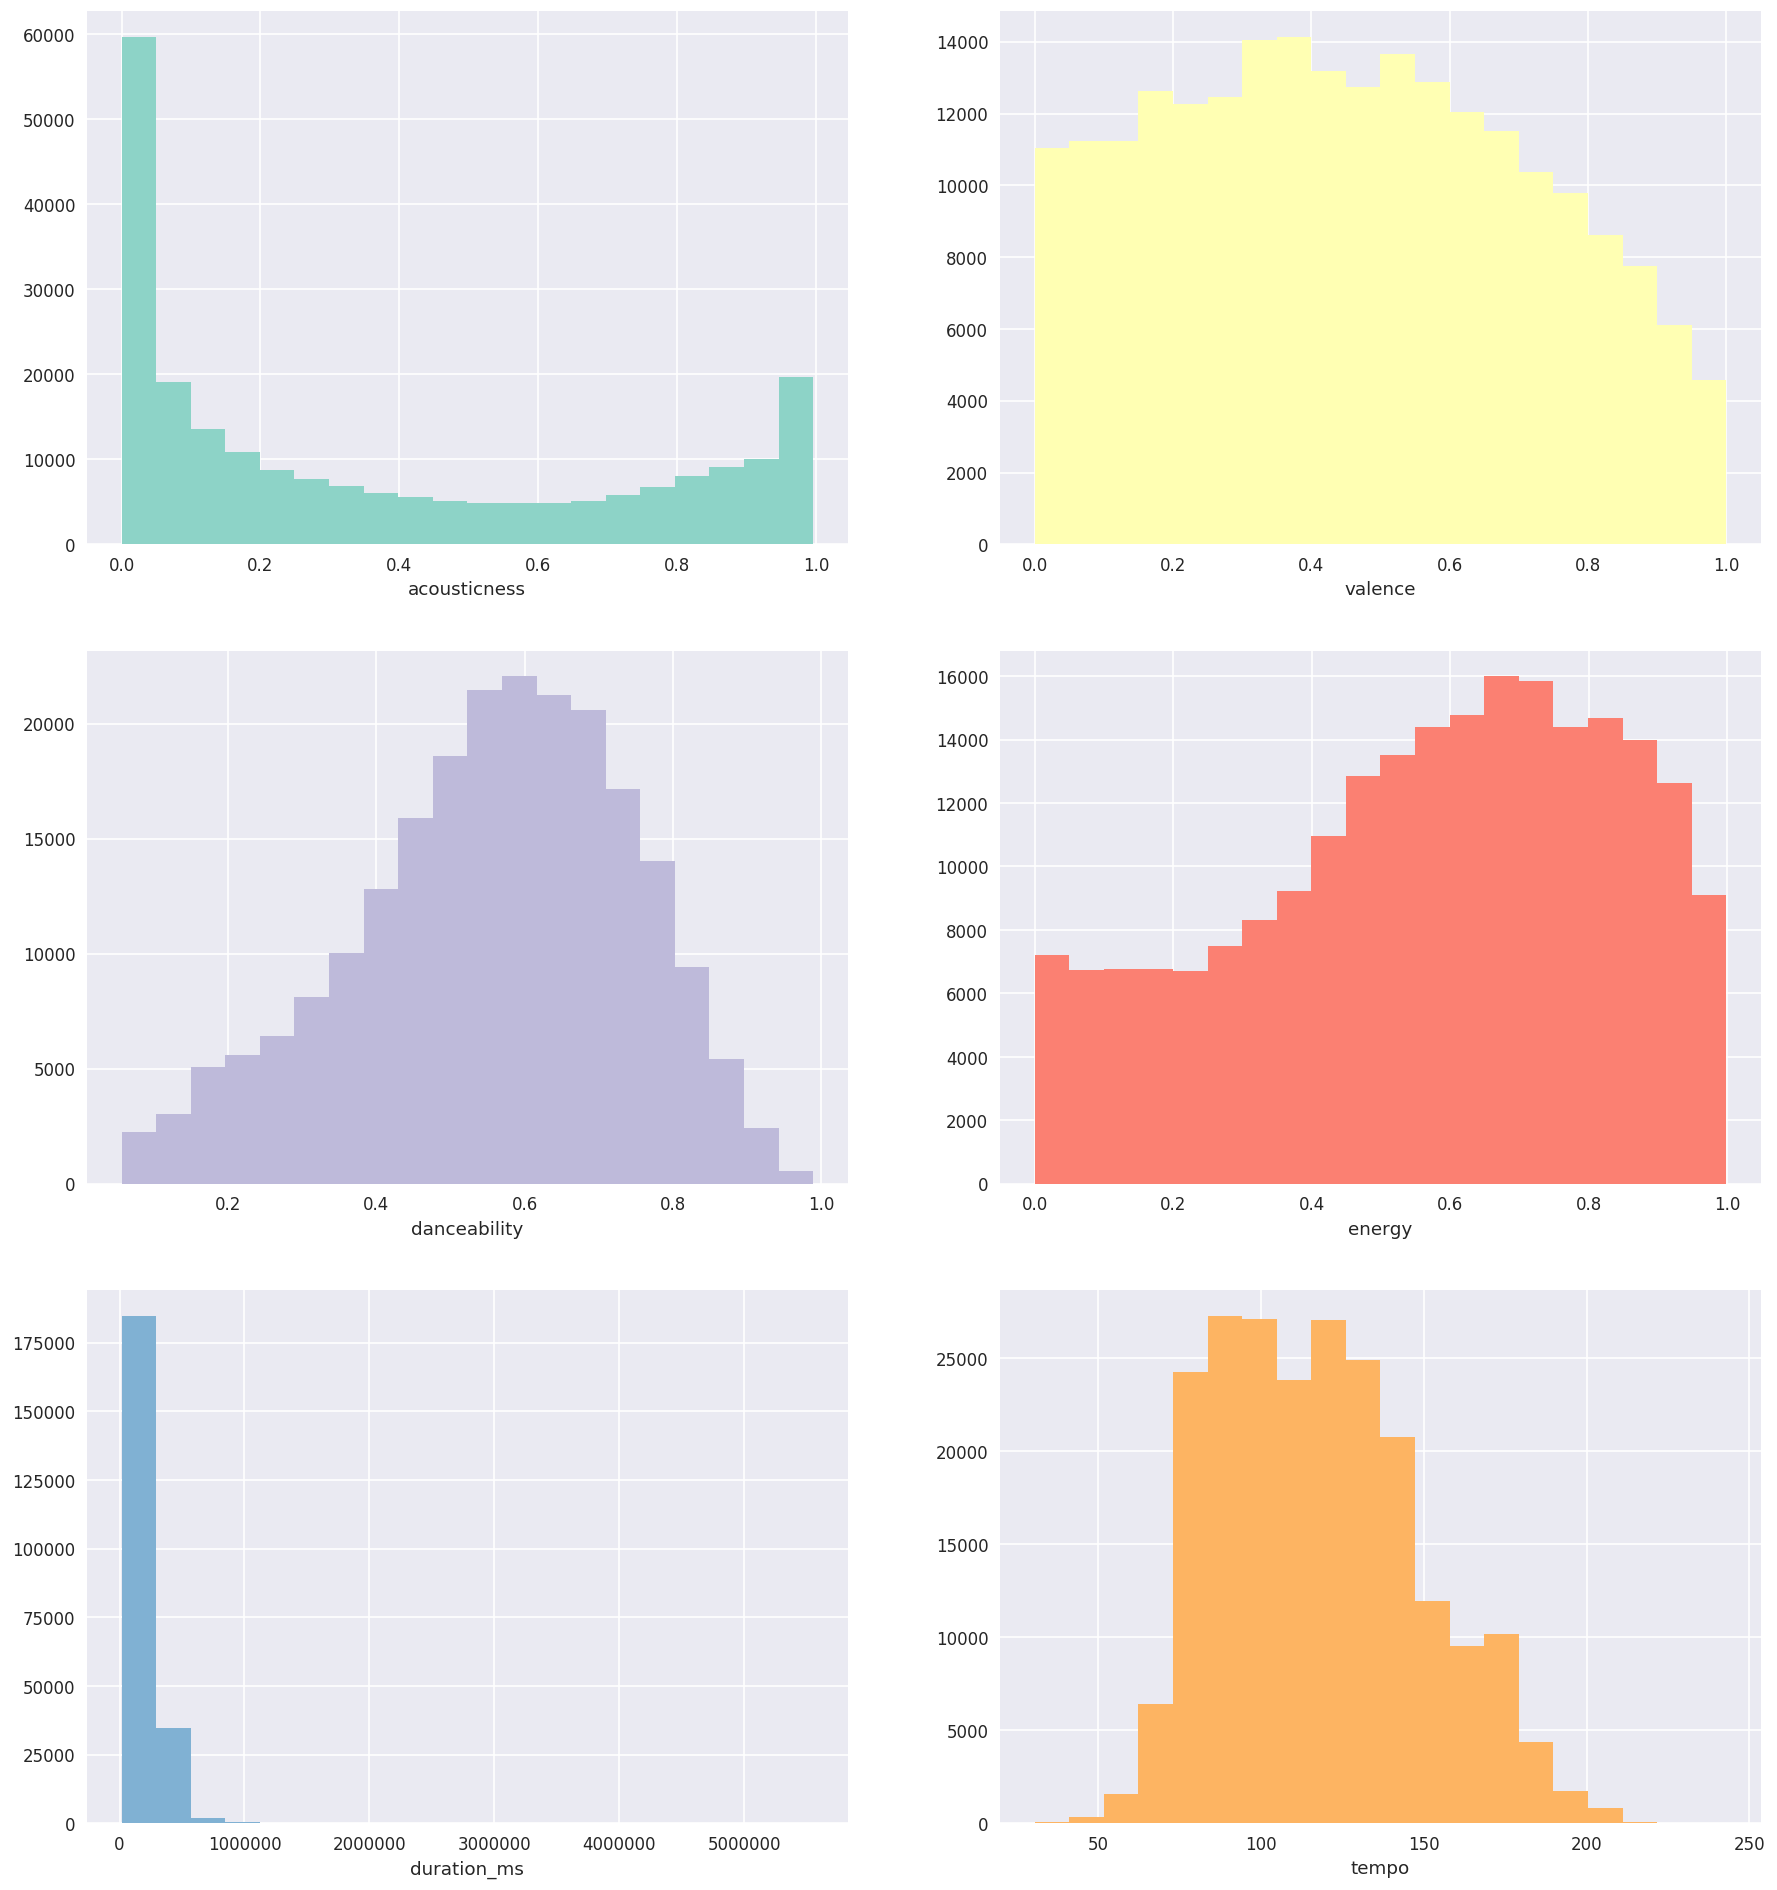

In [20]:
# Setting the colors used in the plots
colors = sns.color_palette('Set3', n_colors=12)

fig, ax = plt.subplots(3,2,figsize=(18,20), dpi=120)
sns.distplot(df_pandas.acousticness, kde=False, bins = 20, color=colors[0], hist_kws=dict(alpha=1), ax=ax[0,0])
sns.distplot(df_pandas.valence, kde=False, bins = 20, color=colors[1], hist_kws=dict(alpha=1), ax=ax[0,1])
sns.distplot(df_pandas.danceability, kde=False, bins = 20, color=colors[2], hist_kws=dict(alpha=1), ax=ax[1,0])
sns.distplot(df_pandas.energy, kde=False, bins = 20, color=colors[3], hist_kws=dict(alpha=1), ax=ax[1,1])
sns.distplot(df_pandas.duration_ms, kde=False, bins = 20, color=colors[4], hist_kws=dict(alpha=1), ax=ax[2,0])
sns.distplot(df_pandas.tempo, kde=False, bins = 20, color=colors[5], hist_kws=dict(alpha=1), ax=ax[2,1])
plt.show()

From the figures above, we can see most of the features have a stable and reasonable distribution that are suitable for us to conduct further analysis directly. However, there are also some features, on which we need to do an adustment in order to make the data more compatible for the model building.  For example, it is clear that some outliers exist in the 'duration_ms' data.  We will consider removing or replacing these outliers in our future analysis, or do transformation to this feature.

__Next, we run a correlation anaylsis on all the numeric features:__

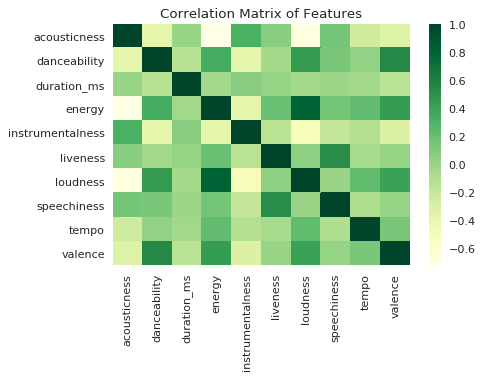

In [21]:
Cols_Num = ['acousticness','danceability','duration_ms', 'energy', 'instrumentalness', 'liveness','loudness', 'speechiness','tempo', 'valence']
plt.figure(figsize=(6,4),dpi=80)
sns.heatmap(data=df_pandas[Cols_Num].corr(), cmap='YlGn')
plt.title('Correlation Matrix of Features')
plt.show()

We noticed that there was a significant positive correlation between:
- Energy & Loudness
- Dancebility & Valence
- Liveness & Speechness 

Also we found that there was a significant negative correlation between:
- Energy & Acousticness
- Loudness & Acousticness
- Loudness & Instrumentalness

Lets select one positive and one negative to see the actual data points, and how sparse it is;

/opt/conda/anaconda/lib/python2.7/site-packages/seaborn/axisgrid.py:1849: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


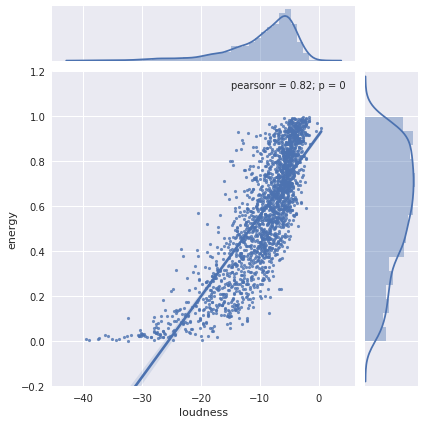

In [22]:
from scipy.stats import pearsonr
df_sample = df_pandas.sample(2000, replace=False)
sns.jointplot(data=df_sample, y='energy',x='loudness',ylim = (-0.2,1.2), kind='reg',stat_func=pearsonr, scatter_kws={'s':10})
plt.ylim = [0.2,1.2]
plt.show()

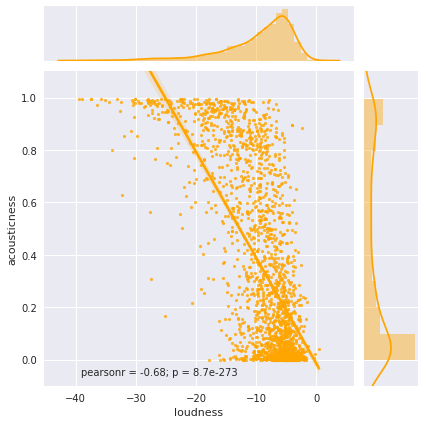

In [23]:
sns.jointplot(data=df_sample, y='acousticness',x='loudness',kind='reg',stat_func=pearsonr, ylim=(-0.1, 1.1), color='orange', scatter_kws={'s':10})
plt.show()

From the graphs above, we can clearly see that as the values of loudness are closer to zero
 - the higher energy value of song is and
 - the lower acousticness of song is

However, due to a more sparse distribution of loudness & energy, there is a more obvious positive linear relationship we can see from the figure.

__Now, lets see how the popularity of the song changes across genres:__

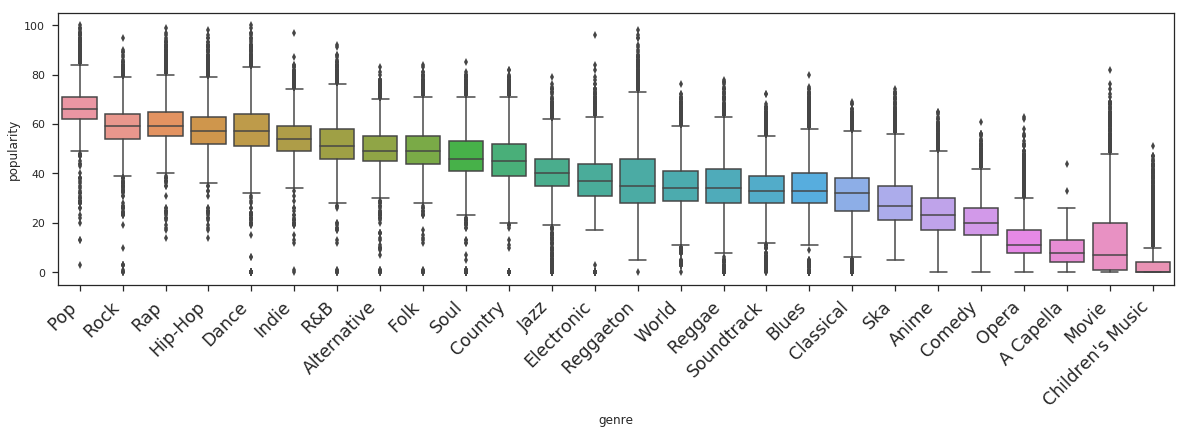

In [24]:
sns.set(style="ticks", palette="pastel")
# Draw a nested boxplot
plt.figure(figsize=(20,5))
my_order = df_pandas.groupby(by=["genre"])["popularity"].median().sort_values(ascending=False).index
chart = sns.boxplot(x="genre", y="popularity",
            data=df_pandas,
            order = my_order)
chart.set_xticklabels(
    chart.get_xticklabels(), 
    rotation=45, 
    horizontalalignment='right',
    fontsize='x-large')
plt.show()

We can see that the genre influences a song's popularity. From the plot above, we can see that Children's Music has the worst popularity, as expected. This is most likely because children are not spending their time listening to music on Spotify.  It is also not beyond our expectation that Movie and Acapella are among the least popular genres, since they are indeed not the preference for most people currently. On the other hand, the pop genre, as its name would suggest, is the most popular one!

__Lets see how other features of the song have an impact on the popularity:__

As columns;

 - "acousticness"
 - "danceability"
 - "energy"
 - "instrumentalness"
 - "liveness"
 - "speechiness"
 - "valence"

Have values ranging between 0 and 1. For a more clear data visualization, we will group them into 5 bins as follows;

In [25]:
from pyspark.ml.feature import Bucketizer

# We create a new dataframe only for the purpose of this plotting, 
# as we don't want to increase the size of the original file by adding these columns

df_buck = df
for x in ["acousticness","danceability","energy","instrumentalness","liveness","speechiness","valence"] :
    bucketizer = Bucketizer(splits=[ 0, .2, .4, .6, .8, 1, float('Inf') ],
                    inputCol=x, outputCol=x + "_bucket")
    df_buck = bucketizer.transform(df_buck)

For the "tempo" column, we will use the QuantileDiscretizer function, by identifying the number of bins that we want;

In [26]:
from pyspark.ml.feature import QuantileDiscretizer

discretizer = QuantileDiscretizer(numBuckets=10, inputCol="tempo", outputCol="tempo_bucket")
df_buck = discretizer.fit(df_buck).transform(df_buck)
df_buck.show(3)
df_buck = df_buck.toPandas().dropna()

+-----+------------------+--------------------+--------------------+----------+------------+------------+-----------+------+----------------+---+--------+--------+-----+-----------+-------+--------------+-------+-------------------+-------------------+-------------+-----------------------+---------------+------------------+--------------+------------+
|genre|       artist_name|          track_name|            track_id|popularity|acousticness|danceability|duration_ms|energy|instrumentalness|key|liveness|loudness| mode|speechiness|  tempo|time_signature|valence|acousticness_bucket|danceability_bucket|energy_bucket|instrumentalness_bucket|liveness_bucket|speechiness_bucket|valence_bucket|tempo_bucket|
+-----+------------------+--------------------+--------------------+----------+------------+------------+-----------+------+----------------+---+--------+--------+-----+-----------+-------+--------------+-------+-------------------+-------------------+-------------+-----------------------+--

Now, we can start plotting the data to see if any patterns arise that are of interest to us

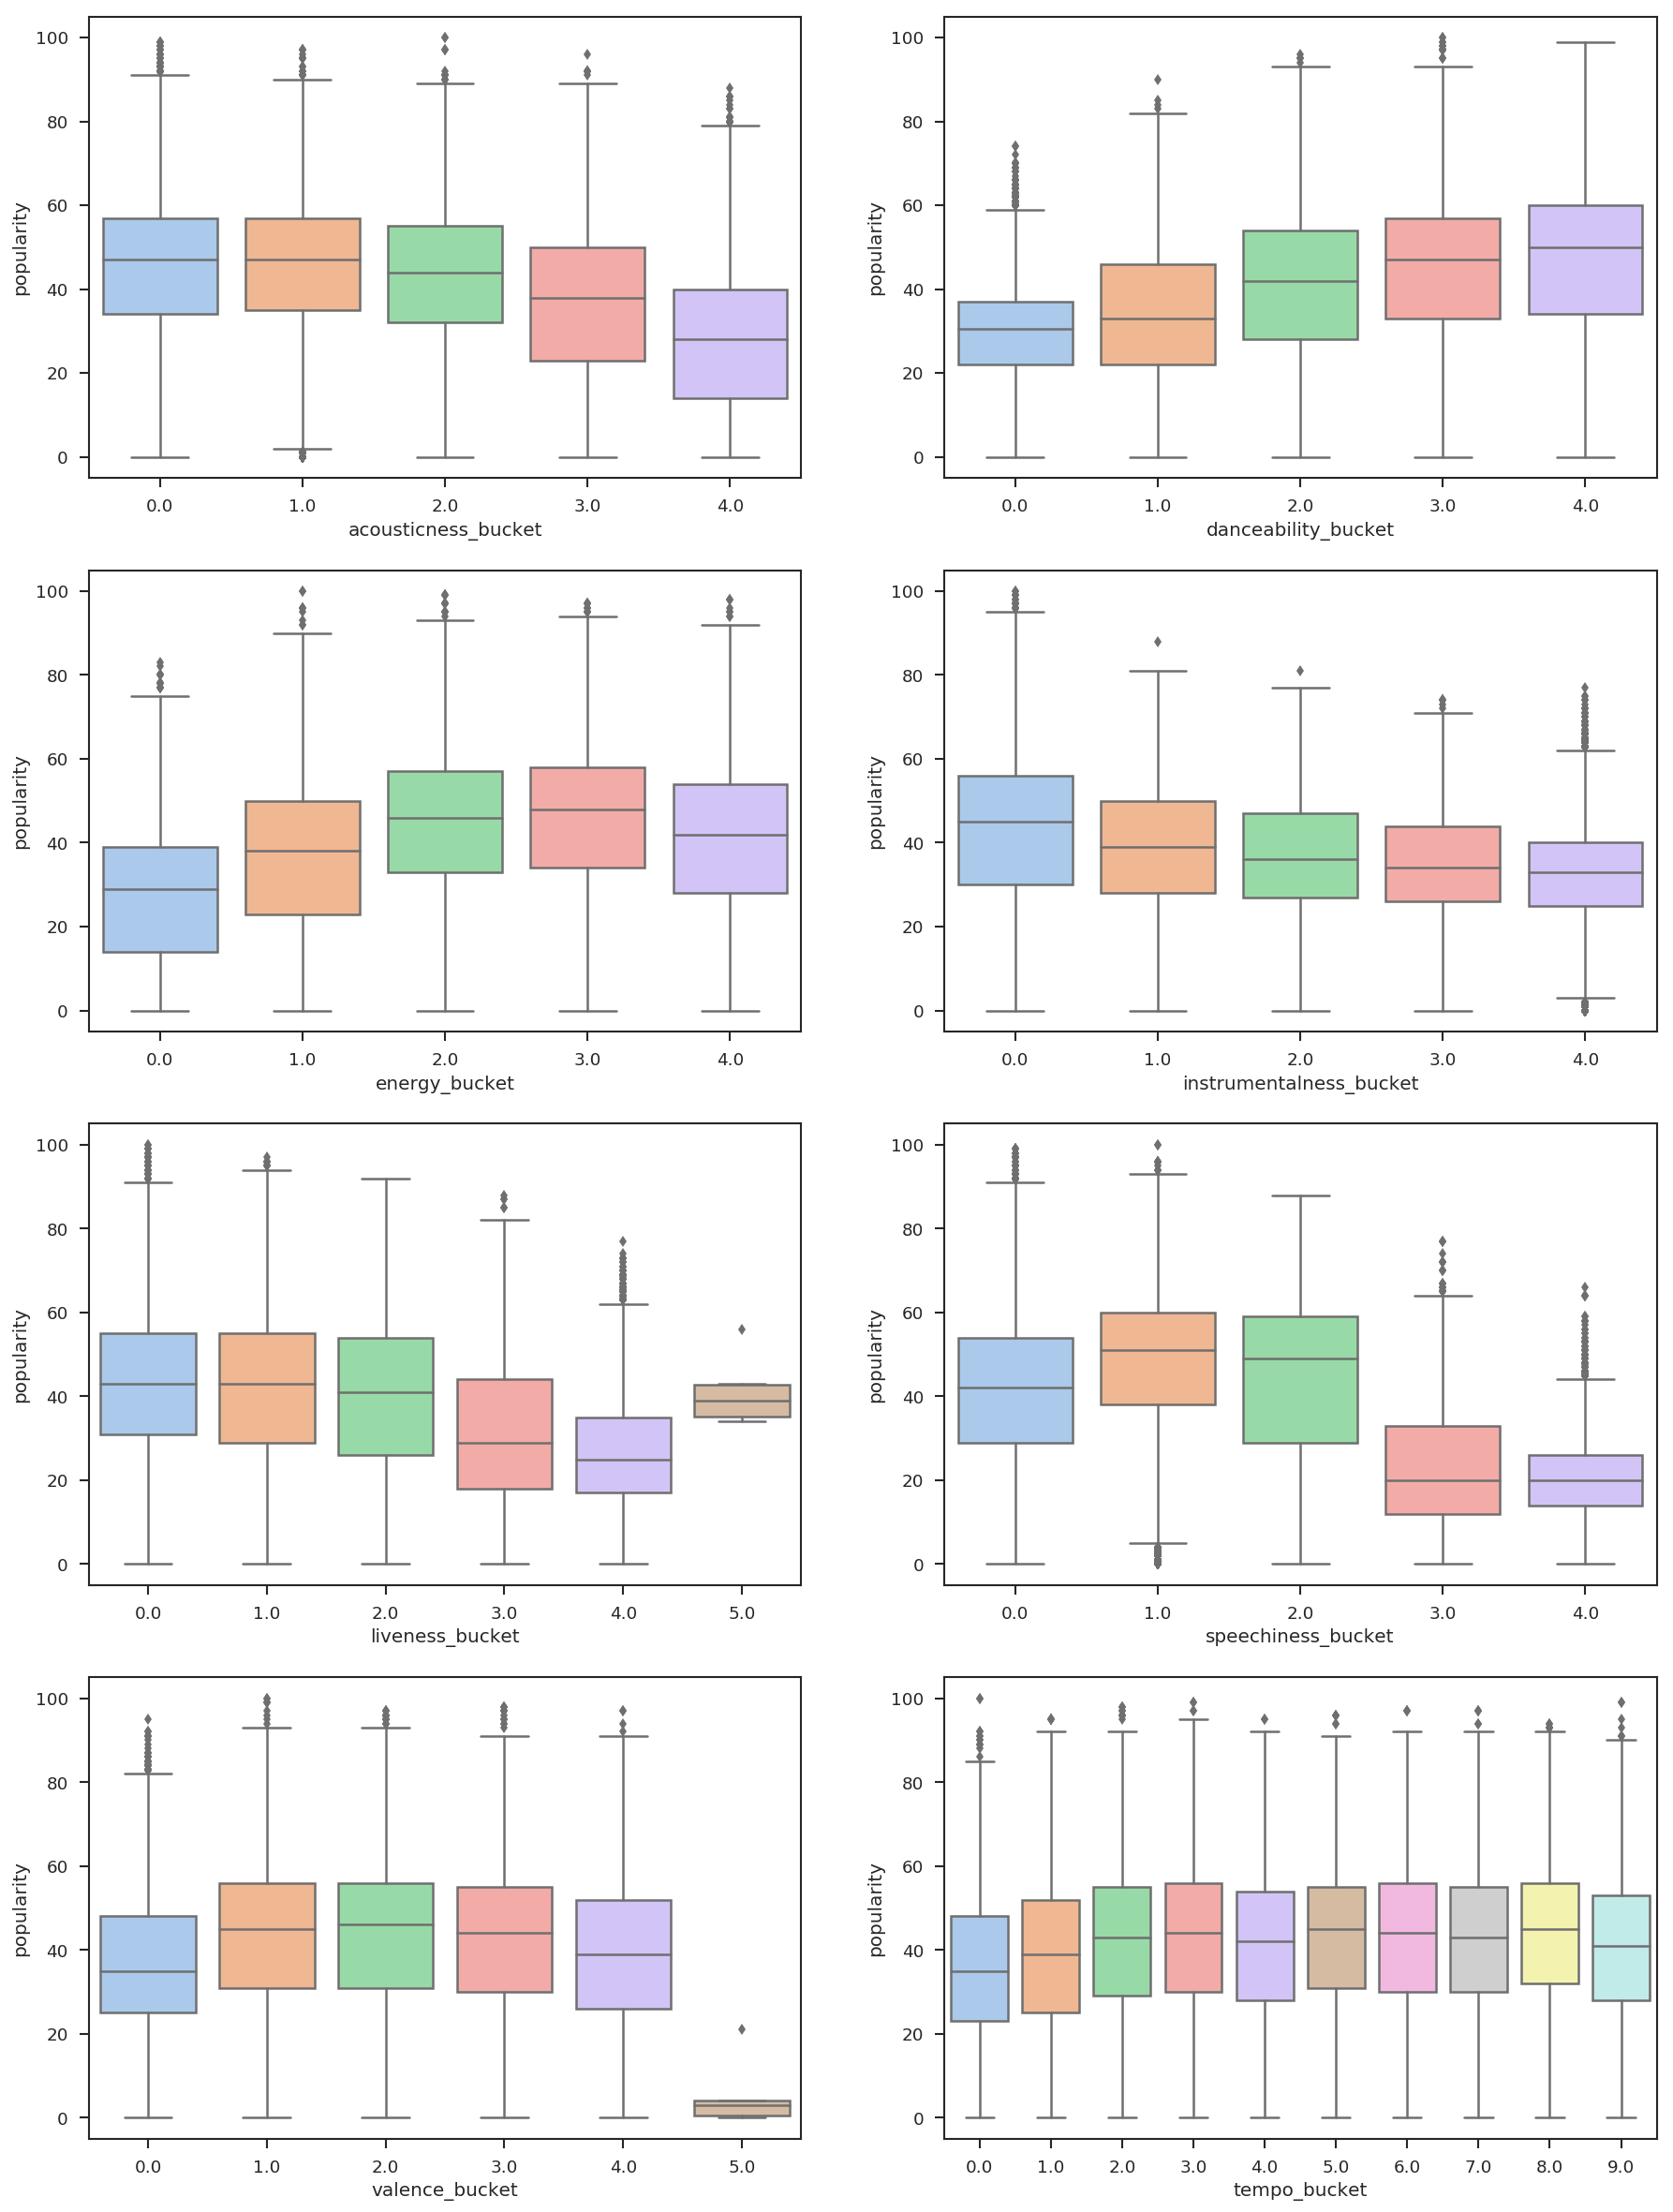

In [27]:
# "acousticnessbucket","danceabilitybucket","energybucket","instrumentalnessbucket","livenessbucket","speechinessbucket","valencebucket"
f, axes = plt.subplots(4, 2,figsize=(18,25), dpi=120)
sns.set(style="ticks", palette="pastel")
sns.boxplot(x="acousticness_bucket", y="popularity", data=df_buck, ax=axes[0,0])
sns.boxplot(x="danceability_bucket", y="popularity", data=df_buck, ax=axes[0,1])
sns.boxplot(x="energy_bucket", y="popularity", data=df_buck, ax=axes[1,0])
sns.boxplot(x="instrumentalness_bucket", y="popularity", data=df_buck, ax=axes[1,1])
sns.boxplot(x="liveness_bucket", y="popularity", data=df_buck, ax=axes[2,0])
sns.boxplot(x="speechiness_bucket", y="popularity", data=df_buck, ax=axes[2,1])
sns.boxplot(x="valence_bucket", y="popularity", data=df_buck, ax=axes[3,0])
sns.boxplot(x="tempo_bucket", y="popularity", data=df_buck, ax=axes[3,1])
plt.show()

__Visualization Summary Insights:__
- The features that have **positive** relationship with popularity: *dancibility, energy,  tempo*
- The features that have **negative** relationship with popularity: *acoustic, instrumental, liveness*
- The features that seem to have **no significant impact** on popularity: *speechness, valence*

It seems that people generally have a preference for more dynamic songs since the features positively related to popularity like dancibility and energy are all a presentation of fast rhythm and tempo. 

# 4. Feature Engineering

Now we are almost stepping into building our model. But before that, we need to do some transformation and preprocessing to our features. This is quite important because the quality of features would greatly impact the model results.

Firstly we decide to discard several columns from putting into our models as features:
- ** track_id** : Just the identiy of each track, meaning nothing.
- ** track_name**: Although the names of the songs should have some impact on their popularity but it's too complicated to be processed as available features. We will, however, transform this to the no. of words instead.
- ** artist_name** : Same as track_name.
- ** duration_ms** : The unit is in millisecond, so we will convert it to minute, as this is a unit listeners care about more.

Then we will create several new features based on the exisiting features  
- ** track_name_length **  : The number of words in each track name  
- ** num_genres ** : Number of different genres a song is catgorized  
- ** duration_min ** : Minutes of the duration of a track  

In [6]:
# Creating 'duration_min'
df = df.withColumn('duration_min', df['duration_ms']/60000)
df = df.drop('duration_ms')

In [7]:
# Creating 'track_name_length'
df = df.withColumn("track_name_length", F.size(F.split(F.col('track_name'), ' ')))

In [8]:
# Creating 'num_genres'
w = Window.partitionBy('track_id')
df = df.withColumn('num_genres', F.count('genre').over(w))

Next, we would like to do something to our **dependent variable popularity**, for certain predictive models. We want to try out both an actual popularity score and a range of score for a regression and a multiclassification problem, respectively.

So, for the classification problems, we need to convert our 'popularity' to labels.   
According to the general standards by Spotify, popularity could be categorized according to the score of popularity as:
- **"Very Popular"** : higher than** 70**
- **"Somewhat Popular"** : between **35 and 70**
- **"Unpopular"** : below **35**

In [9]:
from pyspark.ml.feature import Bucketizer
bucketBorders = [0, 35,  70, 100]
bucketer = Bucketizer(inputCol="popularity", outputCol="pop", splits = bucketBorders)
df = bucketer.transform(df)

In [10]:
df_features = df.select('pop','popularity', 'acousticness','danceability','duration_min','energy','instrumentalness','key','liveness','loudness','mode','speechiness','tempo', 'valence','num_genres', "track_name_length")
df_features = df_features.drop_duplicates().dropna()
df_features.show(5, False)

+---+----------+------------+------------+------------------+------+----------------+---+--------+--------+-----+-----------+-------+-------+----------+-----------------+
|pop|popularity|acousticness|danceability|duration_min      |energy|instrumentalness|key|liveness|loudness|mode |speechiness|tempo  |valence|num_genres|track_name_length|
+---+----------+------------+------------+------------------+------+----------------+---+--------+--------+-----+-----------+-------+-------+----------+-----------------+
|0.0|26        |0.0465      |0.667       |4.72755           |0.714 |1.87E-6         |C  |0.167   |-5.32   |Major|0.0414     |90.014 |0.273  |1         |5                |
|1.0|45        |0.252       |0.635       |3.4526333333333334|0.691 |0.163           |A# |0.0856  |-9.138  |Major|0.0296     |94.968 |0.213  |1         |3                |
|0.0|22        |0.742       |0.331       |3.466666666666667 |0.109 |0.917           |C  |0.118   |-18.923 |Major|0.0384     |130.128|0.0737 |1   

Now we are ready to try several predictive models!

# 4. Machine learning models and prediction

   **—— Which type of songs would be a BLOCKBUSTER!!!**

## 4.1 Linear Regression

We will first try the simplet one, a regression model by using linear regression.   
We use the **Rformula transformer** in order to transform our features into the available and convenient format for machine learning model.

In [33]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import RFormula

In [34]:
# Use RFormula to convert the features to the format that is available and convenient to the models
RF = RFormula(formula="popularity ~ . -pop")
f = RF.fit(df_features).transform(df_features)

In [35]:
train, test = f.randomSplit([0.7, 0.3], seed = 843)

In [36]:
linr = LinearRegression(maxIter=100, regParam=0.2, elasticNetParam=0.7)
linrModel = linr.fit(train)

In [37]:
print("Coefficients: %s" % str(linrModel.coefficients))
print("Intercept: %s" % str(linrModel.intercept))

Coefficients: [-7.440757097646012,9.774758150781,0.20597963695585267,0.0,-0.7326876812256375,0.0,-0.11965906702414422,0.0,0.0,0.46919631909293896,0.0,0.0,0.05695187625989858,0.0,1.0299310967008544,0.4496635498801866,-5.544266217414945,0.37678985336414433,-1.1149450688352922,-7.982971431240144,0.0,-8.557911695334322,9.281705740083872,-0.3446807518777523]
Intercept: 33.521649121


In [38]:
trainingSummary = linrModel.summary

print("RMSE: %f" % trainingSummary.rootMeanSquaredError)
print("r2: %f" % trainingSummary.r2)
print("numIterations: %d" % trainingSummary.totalIterations)
# print("objectiveHistory: %s" % str(trainingSummary.objectiveHistory))

RMSE: 13.964642
r2: 0.367071
numIterations: 33


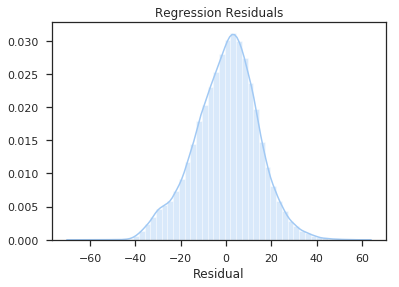

In [39]:
sns.distplot(trainingSummary.residuals.toPandas())
plt.title('Regression Residuals')
plt.xlabel('Residual')
plt.show()

The regression result shows that we have a mean squared error (MSE) of 14 and r-squared of our model is less than 0.5. This means that the model does not have a very stong fit to our data.     

From the residual distribution, we could also see there is quite a number of samples have a residual larger than 10, and some even reaches 40.

## 4.2 Logistic Regression

Now, we will try Logistic Regression, by using 3 pre-defined categories that we transformed from the raw popularity score.

In [18]:
from pyspark.ml.classification import LogisticRegression
from pyspark.mllib.evaluation import MulticlassMetrics

In [41]:
#Select all columns except raw popularity score and transform the dataset

RF = RFormula(formula="pop ~ . - popularity")
f = RF.fit(df_features).transform(df_features)

In [42]:
train, test = f.randomSplit([0.7, 0.3], seed = 843)

In [43]:
lr = LogisticRegression(labelCol="label",featuresCol="features")
lrModel = lr.fit(train)

In [44]:
print("Coefficients: \n" + str(lrModel.coefficientMatrix))
print("Intercept: " + str(lrModel.interceptVector))

Coefficients: 
DenseMatrix([[ 4.71595768e-01, -1.95024967e+00,  2.02340089e-02,
               6.43056241e-01,  1.34655666e+00,  8.43849533e-02,
               1.87810627e-01,  1.48349258e-01,  1.55252085e-01,
              -4.83829825e-03,  8.57734804e-02,  1.05931498e-01,
               4.12350627e-02,  6.19601573e-02, -8.22538674e-02,
              -4.54600832e-02,  7.61114081e-01, -9.38180483e-02,
               8.66654354e-02,  1.33141930e+00, -7.98086752e-04,
               1.01099381e+00, -1.64007536e+00,  2.78577917e-02],
             [-2.73719606e-01, -1.44645708e-01,  4.89975560e-02,
               2.18170605e-01,  9.63985335e-01,  5.98868550e-04,
               2.77341464e-02,  3.73830897e-02,  4.53323415e-02,
               1.98932522e-02,  1.50692278e-02,  1.85269454e-02,
               1.08736848e-02,  2.07783795e-02,  2.41283591e-02,
               4.51774289e-02,  2.46742429e-02, -4.50620788e-02,
              -4.42628683e-02, -6.05700487e-01, -5.69110449e-04,
         

In [45]:
fittedTrain = lrModel.transform(train)
fittedTest = lrModel.transform(test)

metrics_train = MulticlassMetrics(fittedTrain.select('prediction','label').rdd)
metrics_test = MulticlassMetrics(fittedTest.select('prediction','label').rdd)

lr_test_acc = metrics_test.accuracy
lr_test_prc = metrics_test.weightedPrecision
lr_test_rec = metrics_test.weightedRecall
lr_test_f1 = metrics_test.weightedFMeasure()

lr_train_acc = metrics_train.accuracy
lr_train_prc = metrics_train.weightedPrecision
lr_train_rec = metrics_train.weightedRecall
lr_train_f1 = metrics_train.weightedFMeasure()

In [46]:
lr_train_result = [lr_train_acc, lr_train_prc, lr_train_rec, lr_train_f1]
lr_test_result = [lr_test_acc, lr_test_prc, lr_test_rec, lr_test_f1]
lr_result = pd.DataFrame([lr_train_result, lr_test_result], columns=['Accuracy', 'Precision', 'Recall', 'F1_score'], index=['train', 'test']).round(decimals=3)
lr_result

,Accuracy,Precision,Recall,F1_score
train,0.693,0.678,0.693,0.682
test,0.691,0.673,0.691,0.680


## 4.3 Multilayer Perceptron (MLP)

Next, we try Multilayer Perceptron (MLP);

In [47]:
from pyspark.ml.classification import MultilayerPerceptronClassifier

In [48]:
layers = [24, 8, 5, 3]
trainer = MultilayerPerceptronClassifier(maxIter=100, layers=layers, blockSize=128, seed=1234)
mlp_model = trainer.fit(train)

In [49]:
fittedTrain = mlp_model.transform(train)
fittedTest = mlp_model.transform(test)

metrics_train = MulticlassMetrics(fittedTrain.select('prediction','pop').rdd)
metrics_test = MulticlassMetrics(fittedTest.select('prediction','pop').rdd)

In [50]:
mlp_test_acc = metrics_test.accuracy
mlp_test_prc = metrics_test.weightedPrecision
mlp_test_rec = metrics_test.weightedRecall
mlp_test_f1 = metrics_test.weightedFMeasure()

mlp_train_acc = metrics_train.accuracy
mlp_train_prc = metrics_train.weightedPrecision
mlp_train_rec = metrics_train.weightedRecall
mlp_train_f1 = metrics_train.weightedFMeasure()

In [51]:
mlp_train_result = [mlp_train_acc, mlp_train_prc, mlp_train_rec, mlp_train_f1]
mlp_test_result = [mlp_test_acc, mlp_test_prc, mlp_test_rec, mlp_test_f1]
mlp_result = pd.DataFrame([mlp_train_result, mlp_test_result], columns=['Accuracy', 'Precision', 'Recall', 'F1_score'], index=['train', 'test']).round(decimals=3)
mlp_result

,Accuracy,Precision,Recall,F1_score
train,0.625,0.645,0.625,0.612
test,0.622,0.643,0.622,0.608


## 4.4 PCA

Since we noticed that there are quite a lot of audio features that are correlated with each other, we want to see whether PCA would better improve our model by extracting the common factors and revmoving other potential noise.

In [19]:
supervised = RFormula(formula="pop ~ .-duration_ms-mode-key-num_genres-track_name_length")
fittedRF = supervised.fit(df_features)  
preparedDF_pca = fittedRF.transform(df_features)  

In [20]:
from pyspark.ml.feature import PCA as PCAml
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import MinMaxScaler
from pyspark.sql.functions import udf

In [21]:
# First scale the varibles 
scaler = MinMaxScaler(inputCol="features", outputCol="scaledFeatures")
scalerModel = scaler.fit(preparedDF_pca)
scaledData = scalerModel.transform(preparedDF_pca)

### 4.4.1 We will first try extracting 2 principle factors (i.e. k = 2)

In [22]:
pca = PCAml(k=2, inputCol="scaledFeatures", outputCol="pca")
model = pca.fit(scaledData)
transformed = model.transform(scaledData)

In [23]:
# Turn the pca results into dataframe
firstElement=udf(lambda v:float(v[0]),FloatType())
secondElement=udf(lambda v:float(v[1]),FloatType())
pcaDF = transformed.select(firstElement('pca'), secondElement('pca'), 'pop').toPandas()
pcaDF.columns = ['pc1', 'pc2', 'label']

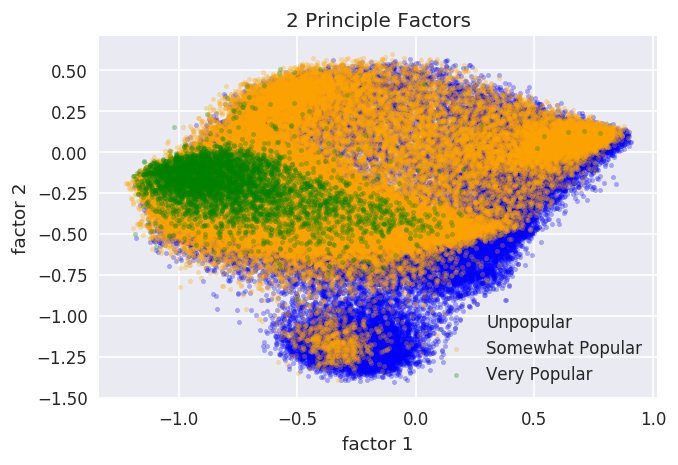

In [24]:
colors =['b', 'orange', 'g']
plt.figure(figsize=(6,4), dpi=120)
for index in range(3):
    temp = pcaDF[pcaDF['label'] == index]
    plt.scatter(temp['pc1'], temp['pc2'], c=colors[index], cmap='brg', alpha=0.3, s=10,  marker='8', linewidth=0)  
plt.title('2 Principle Factors')
plt.xlabel('factor 1')
plt.ylabel('factor 2')
plt.legend(['Unpopular', 'Somewhat Popular', 'Very Popular'])
plt.show()

In [58]:
print 'The cumulative variance that top 2 factors could explain:', np.sum(model.explainedVariance)

The cumulative variance that top 2 factors could explain: 0.6057552122902583


### 4.4.2 When k =4

In [59]:
pca = PCAml(k=4, inputCol="scaledFeatures", outputCol="pca")
modelk4 = pca.fit(scaledData)
transformed = model.transform(scaledData)
transformed = transformed.drop('label','features')

In [60]:
print 'The cumulative variance that top 4 factors could explain:', np.sum(modelk4.explainedVariance)

The cumulative variance that top 4 factors could explain: 0.816543979747772


4 factors could explain 80% of the information, so would will try using these factors to rebuild our logistic regression model and see whether any improvements are made.

In [61]:
supervised = RFormula(formula="pop ~ pca+duration_min+mode+key+num_genres+track_name_length")
fittedRF = supervised.fit(transformed)  
preparedDF_pca = fittedRF.transform(transformed)  

In [62]:
train, test =preparedDF_pca.randomSplit([0.7, 0.3], seed = 843)

In [63]:
lr = LogisticRegression(labelCol="label",featuresCol="features")
lrModel_pca = lr.fit(train)

In [64]:
fittedTrain = lrModel_pca.transform(train)
fittedTest = lrModel_pca.transform(test)

metrics_train = MulticlassMetrics(fittedTrain.select('prediction','pop').rdd)
metrics_test = MulticlassMetrics(fittedTest.select('prediction','pop').rdd)

lr_pca_test_acc = metrics_test.accuracy
lr_pca_test_prc = metrics_test.weightedPrecision
lr_pca_test_rec = metrics_test.weightedRecall
lr_pca_test_f1 = metrics_test.weightedFMeasure()

lr_pca_train_acc = metrics_train.accuracy
lr_pca_train_prc = metrics_train.weightedPrecision
lr_pca_train_rec = metrics_train.weightedRecall
lr_pca_train_f1 = metrics_train.weightedFMeasure()

In [131]:
train_result = [lr_pca_train_acc, lr_pca_train_prc, lr_pca_train_rec, lr_pca_train_f1]
test_result = [lr_pca_test_acc, lr_pca_test_prc, lr_pca_test_rec, lr_pca_test_f1]
lr_pca_result = pd.DataFrame([train_result, test_result], columns=['Accuracy', 'Precision', 'Recall', 'F1_score'], index=['train', 'test']).round(decimals=3)
lr_pca_result

,Accuracy,Precision,Recall,F1_score
train,0.671,0.662,0.671,0.660
test,0.673,0.654,0.673,0.662


Below, we show the result from the original logistic regression model again for a clearer comparison.

In [132]:
lr_result

,Accuracy,Precision,Recall,F1_score
train,0.693,0.678,0.693,0.682
test,0.691,0.673,0.691,0.680


We can see that the result from using PCA doesn't actually improve the accuracy of the model.

Next section, we will try to tune some model, by elasticity and regularization hyperparameters, to see if the result improve.

## 4.5 Hyperparameter Tuning (using Pipeline)

First, we import libraries to used;

In [88]:
from pyspark.ml import Pipeline
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator, TrainValidationSplit
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
import numpy as np

In [ ]:
#Create new train and testing dataset
train2, test2= df_features.randomSplit([0.7, 0.3], seed = 843)

We will start with Logistic Regression;

In [83]:
rForm = RFormula()
lr = LogisticRegression(labelCol="label",featuresCol="features")

In [84]:
stages = [rForm, lr]  # setting the stages
pipeline = Pipeline().setStages(stages)  # adding the stages to the pipeline

reg_params = [0.01, 0.1, 1.0]
elas_params = [0.3, 0.7]

params_lr = ParamGridBuilder()\
    .addGrid(rForm.formula, ["pop ~ . - popularity"])\
    .addGrid(lr.elasticNetParam, elas_params)\
    .addGrid(lr.regParam, reg_params)\
    .build()

In [91]:
MultiEva = MulticlassClassificationEvaluator()

In [92]:
tvs = TrainValidationSplit()\
  .setTrainRatio(0.75)\
  .setEstimatorParamMaps(params_lr)\
  .setEstimator(pipeline)\
  .setEvaluator(MultiEva)

In [ ]:
tvsFitted = tvs.fit(train2)

In [134]:
print("F1_score: %f" % MultiEva.evaluate(tvsFitted.transform(train2)))

F1_score: 0.678784


In [135]:
print("F1_score: %f" % MultiEva.evaluate(tvsFitted.transform(test2)) )

F1_score: 0.677690


Again, below is the original result from the logistic regression model for a clearer comparision

In [133]:
lr_result

,Accuracy,Precision,Recall,F1_score
train,0.693,0.678,0.693,0.682
test,0.691,0.673,0.691,0.680


The results from tuning are actually worse!

__Lets try tuning for linear regression model;__

In [102]:
from pyspark.ml.evaluation import RegressionEvaluator

linear = LinearRegression(labelCol="label",featuresCol="features")

In [103]:
stages_linear = [rForm, linear]  # setting the stages
pipeline_linear = Pipeline().setStages(stages_linear)  # adding the stages to the pipeline

# We will use the same regularize and elastic parameters from above

params_linear = ParamGridBuilder()\
    .addGrid(rForm.formula, ["popularity ~ . - pop"])\
    .addGrid(lr.elasticNetParam, elas_params)\
    .addGrid(lr.regParam, reg_params)\
    .build()

In [106]:
LinearEva = RegressionEvaluator()

In [107]:
tvs_linear = TrainValidationSplit()\
  .setTrainRatio(0.75)\
  .setEstimatorParamMaps(params_linear)\
  .setEstimator(pipeline_linear)\
  .setEvaluator(LinearEva)

In [108]:
tvsFitted_linear = tvs_linear.fit(train2)

In [122]:
print("MSE: %f" % LinearEva.evaluate(tvsFitted_linear.transform(train2)))

MSE: 13.951557


In [129]:
print("MSE: %f" % LinearEva.evaluate(tvsFitted_linear.transform(test2)))

MSE: 14.023015


In [136]:
print("Original RMSE: %f" % trainingSummary.rootMeanSquaredError)

Original RMSE: 13.964642


The model is a little bit better in predicting the testing dataset!

# 5.Summary

In summary, we have conducted data exploratory analysis and have built several models for predicting the popularity of songs.   
In ** data exploratory analysis**, we found that:
- The most popular songs only account for a small proportion.
- Several audio features have high correlation with each other.
- Popularity has a significant relationship with genres.
- Popularity is also highly correlated with some audio features such as energy and speechiness.  

In ** predictive model** , we found that: 
- Logistic regression had the highest overall accuracy (0.69) and f1 score (0.68) , compared with MLP, linear regression and the logistic regression after PC.
- It also has roughly the same performance on both training and testing
- PCA result shows that the information of audio features could be explained by only several factors. 
- We tuned our models by changing several factors, including elasticity and regularization, and the result didn’t improve much


There are still areas where the model could be improved in the future.  From our point of view, the potential reasons that might have lowered the accuracy of our models include:
- **Audio features alone may only account for a small portion of deciding whether a song could be popular or not. **We need to consider other external factors, such as more information from 
    - the artists (Whether or not he/she has ever been nominated for a Grammy Award) 
    - the producer, 
    - the music video popularity, 
    - how the songs are publicized, 
    - and the overall changing preference of listeners  
- **The number of different labels in the samples are not balanced.** The 'Very Popular' naturally accounts for a small proportion of all songs.
- Although Spotify is one of the biggest international media service streaming companies, **its popularity index only reflects the popularity in the streaming media channel.** It failed to account for the popularity from other channels (Apple Music, Google Play, etc.). 
- More complex techniques and models could be used for further anlysis of this topic, such as NLP and Network Analysis.
	